<a href="https://colab.research.google.com/github/desmondcheongzx/COVID-19-Modelling/blob/master/pollution_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import seaborn as sns
import math
import pandas as pd
import sqlite3
import csv
import re
import matplotlib.pyplot as plt
import plotly.express as px
import scipy
import statsmodels.api as sm
import statsmodels.tools
import sklearn.linear_model
import sklearn.model_selection
import sklearn.metrics
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import PolynomialFeatures, normalize
import random

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
conn = sqlite3.connect("/content/ForecastingData.db")
c = conn.cursor()
c.execute('PRAGMA foreign_keys = ON')

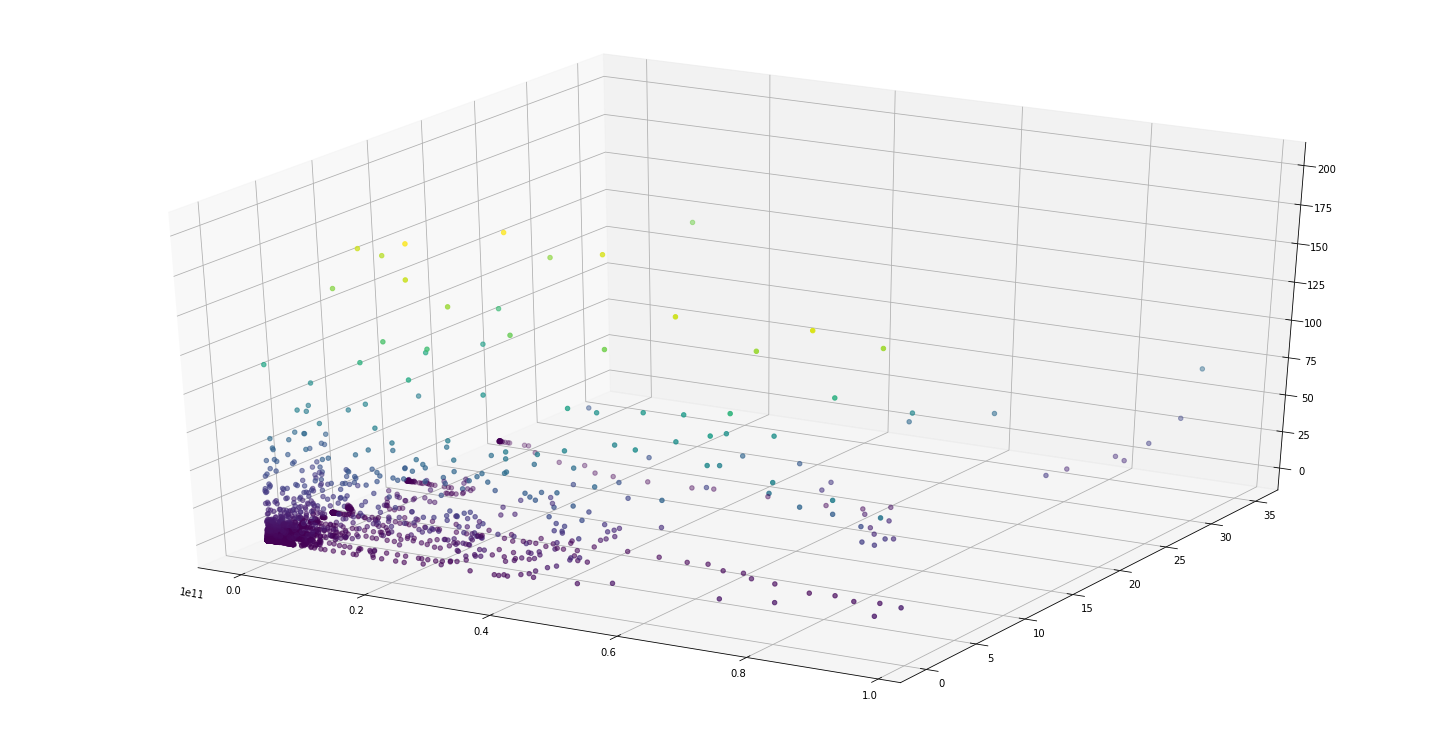

In [6]:
'''
plt.figure(figsize=(20, 10))
plt.title("Outbreak trends")
plt.xlabel("Infections times susceptible")
plt.ylabel("Delta infections")
'''
locations = []

fig = plt.figure(figsize=(20, 10))
ax = Axes3D(fig)

c.execute('SELECT DISTINCT location FROM cities WHERE pm25 IS NOT NULL AND no2 IS NOT NULL AND so2 IS NOT NULL AND co IS NOT NULL AND o3 IS NOT NULL;')
for row in c:
    locations.append(row[0])

X = []
Y = []
Z = []
for location in locations:

    start = False
    counter = 0
    
    c.execute('SELECT delta_infected, susceptible, infected, deaths,so2,no2,o3,co,pm25,lockdown FROM cities WHERE location="'+location+'" AND pm25 IS NOT NULL AND no2 IS NOT NULL AND so2 IS NOT NULL AND co IS NOT NULL AND o3 IS NOT NULL ORDER BY DATE ASC;')
    for entry in c:
        include = True
        delta_infected = entry[0]
        susceptible = entry[1]
        infected = entry[2]
        deaths = entry[3]
        if infected*susceptible > 100000000000 or delta_infected > 200:
            #print(location)
            include = False
        if infected > 0:
            start = True
        if start != True or include == False:
            continue
        X.append(susceptible*infected)
        Z.append(delta_infected)
        counter += 1
        Y.append(deaths)
        #max_y = max(max_y, entry[0])
        #maxxx = max(maxxx, entry[0])

        
    # Plot and show
    #if include == True:
        #plt.scatter(X, Y, label=location)

#plt.scatter(X, Y, alpha=0.1)
#plt.legend()
ax.scatter(X, Y, Z, c=Z, cmap='viridis')
#ax.plot_trisurf(X, Y, Z, cmap='viridis', edgecolor=label'none', alpha=0.3)
plt.show()

conn.commit()

In [9]:
X = []
Y = []

for location in locations:
    start = False
    counter = 0
    include = True
    
    c.execute('SELECT delta_infected, susceptible, infected, recovered, deaths,density, so2,no2,o3,co,pm25,lockdown FROM cities WHERE location="'+location+'" AND pm25 IS NOT NULL AND no2 IS NOT NULL AND so2 IS NOT NULL AND co IS NOT NULL AND o3 IS NOT NULL ORDER BY DATE ASC;')
    rows = []
    for entry in c:
        rows.append(entry)
    for i, entry in enumerate(rows):
        if i <= 1:
            continue
        if i == len(rows)-1:
            continue
        delta_infected = rows[i+1][0]
        susceptible = entry[1]
        infected = entry[2]
        recovered = entry[3]
        deaths = entry[4]
        density = entry[5]
        so2=float(entry[6])
        no2=float(entry[7])
        o3=float(entry[8])
        co=float(entry[9])
        pm25=float(entry[10])
        lockdown = entry[11]
        prev_infected = rows[i-1][2]
        prev_prev_infected = rows[i-2][2]
        density = entry[5]

        #if entry[0] > 4000:
            #print(location)
            #include = False
        if infected > 0:
            start = True
        if start != True:
            continue
        X.append([counter, susceptible, infected, recovered, deaths, susceptible*infected, prev_infected, density,so2,no2,o3,co,pm25,lockdown])
        counter += 1
        Y.append(delta_infected)
        #max_y = max(max_y, entry[0])
        #maxxx = max(maxxx, entry[0])
X = sm.add_constant(X)
#print(X)
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     1402.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):               0.00
Time:                        07:23:36   Log-Likelihood:                -20865.
No. Observations:                2840   AIC:                         4.176e+04
Df Residuals:                    2825   BIC:                         4.185e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.3683     34.516      0.967      0.334     -34.311     101.047
x1            -0.2589      0.524     -0.494      0.621      -1.286       0.768
x2          7.907e-08    4.3e-08      1.839      0.066   -5.22e-09    1.63e-07
x3             0.6554      0.015     42.919      0.000       0.625       0.685
x4            -0.0106      0.002     -4.878      0.000      -0.015      -0.006
x5             0.1884      0.029      6.413      0.000       0.131       0.246
x6          2.651e-10   1.35e-11     19.667      0.000    2.39e-10    2.92e-10
x7            -0.6278      0.015    -40.795      0.000      -0.658      -0.598
x8            -0.1297      0.067     -1.950      0.051      -0.260       0.001
x9            -6.5966      6.403     -1.030      0.303     -19.151       5.958
x10            1.1171      2.125      0.526      0.599      -3.050       5.284
x11            5.2757      1.534      3.439      0.001       2.268       8.284
x12          -25.5062      5.664     -4.503      0.000     -36.613     -14.399
x13            0.1949      0.367      0.530      0.596      -0.526       0.916
x14           52.4952     19.389      2.707      0.007      14.477      90.513
==============================================================================
Omnibus:                     3621.609   Durbin-Watson:                   1.425
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4884709.500
Skew:                           6.088   Prob(JB):                         0.00
Kurtosis:                     205.808   Cond. No.                     5.38e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.38e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Held-out data from  China, Xinjiang
Number of data points:  2714
Number of training points:  1899
Number of validation points:  815

Training r^2:  0.8956026417512813
Training RMSE:  345.8986739784929

Validation r^2:  0.8612403043881479
Validation RMSE:  358.1286544201104

Average y_val:  177.4723926380368
STD y_val:  961.4072696806952


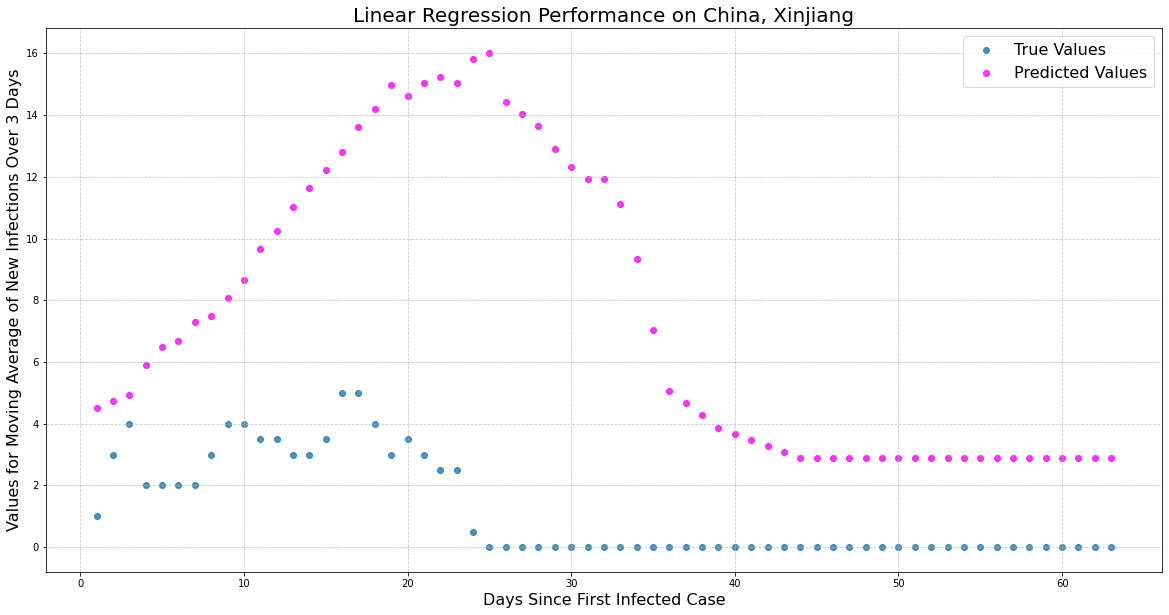

In [10]:
X = []
Y = []

test_country = random.choice(locations)
while(test_country == "China, Hubei"):
    test_country = random.choice(locations)

for location in locations:
    if location == "China, Hubei":
        continue
    if location == test_country:
        print("Held-out data from ", location)
        continue
    start = False
    counter = 1
    
    c.execute('SELECT delta_infected, susceptible, infected,recovered, deaths,density, so2,no2,o3,co,pm25,lockdown FROM cities WHERE location="'+location+'" AND pm25 IS NOT NULL AND no2 IS NOT NULL AND so2 IS NOT NULL AND co IS NOT NULL AND o3 IS NOT NULL ORDER BY DATE ASC;')
    rows = []
    for entry in c:
        rows.append(entry)
    for i, entry in enumerate(rows):
        if i <= 1:
            continue
        if i == len(rows)-1:
            continue
        include = True
        delta_infected = rows[i+1][0]
        susceptible = entry[1]
        infected = entry[2]
        recovered = entry[3]
        deaths = entry[4]
        density = entry[5]
        so2=float(entry[6])
        no2=float(entry[7])
        o3=float(entry[8])
        co=float(entry[9])
        pm25=float(entry[10])
        lockdown = entry[11]
        prev_infected = rows[i-1][2]
        population = susceptible + infected + recovered + deaths
        #if infected > 80000:
            #print(location)
            #include = False
        #if delta_infected < 50:
            #print(location)
            #include = False
        if infected > 0:
            start = True
        if start != True or include == False:
            continue
        X.append([counter, infected, deaths, co, so2, no2, lockdown])
        counter += 1
        Y.append(delta_infected)
        #max_y = max(max_y, entry[0])
        #maxxx = max(maxxx, entry[0])

        
poly = PolynomialFeatures(6)
#poly.fit_transform(X)
print("Number of data points: ", len(Y))
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, Y, test_size=0.3)
print("Number of training points: ", len(y_train))
lm = sklearn.linear_model.Lasso(normalize=True)
model = lm.fit(X_train, y_train)
y_train_pred = model.predict(X_train)

#X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_rest, y_rest, test_size=0.5)
print("Number of validation points: ", len(y_val))
#print("Number of testing points: ", len(y_test))
y_val_pred = model.predict(X_val)

print()
print("Training r^2: ", model.score(X_train, y_train))
print("Training RMSE: ", math.sqrt(sklearn.metrics.mean_squared_error(y_train, y_train_pred)))
print()
print("Validation r^2: ", model.score(X_val, y_val))
print("Validation RMSE: ", math.sqrt(sklearn.metrics.mean_squared_error(y_val_pred, y_val)))

print()
print("Average y_val: ", np.average(y_val))
print("STD y_val: ", np.std(y_val))

plt.figure(figsize=(20, 10))
plt.title("Linear Regression Performance on " + test_country, fontsize=20)
plt.xlabel("Days Since First Infected Case", fontsize=16)
plt.ylabel("Values for Moving Average of New Infections Over 3 Days", fontsize=16)

graphX = []
testX = []
graphY = []
predY = []

c.execute('SELECT delta_infected, susceptible, infected, recovered, deaths, density, so2,no2,o3,co,pm25,lockdown FROM cities WHERE location="'+test_country+'"  AND pm25 IS NOT NULL AND no2 IS NOT NULL AND so2 IS NOT NULL AND co IS NOT NULL AND o3 IS NOT NULL ORDER BY DATE ASC;')
start = False
include = True
counter = 1
rows = []
for entry in c:
    rows.append(entry)
for i, entry in enumerate(rows):
    if i <= 1:
        continue
    if i == len(rows)-1:
        continue
        
    delta_infected = rows[i+1][0]
    susceptible = entry[1]
    infected = entry[2]
    recovered = entry[3]
    deaths = entry[4]
    so2=float(entry[6])
    no2=float(entry[7])
    o3=float(entry[8])
    co=float(entry[9])
    pm25=float(entry[10])
    lockdown = entry[11]
    prev_infected = rows[i-1][2]
    population = susceptible + infected + recovered + deaths
    #if delta_infected < 50:
        #print(location)
        #include = False
    if infected > 0:
        start = True
    if start != True or include == False:
        continue
    testX.append([counter, infected, deaths, co, so2,no2,lockdown])
    graphX.append([counter])
    counter += 1
    graphY.append(delta_infected)
predY = model.predict(testX)

plt.grid(linestyle='--', alpha=0.7)
plt.scatter(graphX, graphY, alpha=0.8, label="True Values")
plt.scatter(graphX, predY, alpha=0.8, c="magenta", label="Predicted Values")
plt.legend(prop={"size":16})
plt.show()


In [0]:
X = []
Y = []

for location in locations:
    start = False
    counter = 1
    include = True
    
    c.execute('SELECT delta_infected, susceptible, infected, recovered, deaths FROM cities WHERE location="'+location+'" ORDER BY DATE ASC;')
    for entry in c:
        susceptible = entry[1]
        infected = entry[2]
        recovered = entry[3]
        deaths = entry[4]
        population = susceptible + infected + recovered + deaths
        #if entry[0] > 4000:
            #print(location)
            #include = False
        if entry[0] > 0:
            start = True
        if start != True:
            continue
        X.append([counter, susceptible, ])
        counter += 1
        Y.append(infected)
        #max_y = max(max_y, entry[0])
        #maxxx = max(maxxx, entry[0])

X = sm.add_constant(X)
#print(X)
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     1198.
Date:                Sun, 12 Apr 2020   Prob (F-statistic):               0.00
Time:                        02:51:06   Log-Likelihood:                -36966.
No. Observations:                3789   AIC:                         7.394e+04
Df Residuals:                    3784   BIC:                         7.397e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -178.5875    140.158     -1.274      0.203    -453.380      96.205
x1            22.4568      3.679      6.105      0.000      15.245      29.669
x2          1.063e-06   3.91e-07      2.719      0.007    2.97e-07    1.83e-06
x3            -0.3676      0.019    -19.001      0.000      -0.406      -0.330
x4            11.0207      0.177     62.354      0.000      10.674      11.367
==============================================================================
Omnibus:                     5942.845   Durbin-Watson:                   0.243
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4100942.329
Skew:                           9.838   Prob(JB):                         0.00
Kurtosis:                     162.965   Cond. No.                     3.87e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.87e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [0]:
print(len(locations))

59
